In [2]:
datadir = '../Datasets/'

In [3]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter

In [4]:
#Generate git hub dev graph
## GitHub Developers (undirected)
D = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
git = ig.Graph.TupleList(tuples, directed = False)

## read node features
X = pd.read_csv(datadir+'GitHubDevelopers/musae_git_target.csv')

## map node names in edgelist to indices in the graph
idx = [int(i) for i in git.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex) 
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)

cls = ['grey','black'] ## node colors
lbl = ['web','ml']     ## node labels
git.es['color'] = 'grey' ## edge color

## there are 2 node types: ml or web
git.vs['color'] = [cls[i] for i in list(X['ml_target'])]
git.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]


In [5]:
#Generate ml and web graph
gh_ml = git.subgraph([v for v in git.vs() if v['lbl']=='ml'])
#drop isolated vertices and remove any loops
gh_ml = gh_ml.subgraph([v for v in gh_ml.vs() if v.degree()>0])
gh_ml = gh_ml.simplify(multiple=False)
gh_web = git.subgraph([v for v in git.vs() if v['lbl']=='web'])
gh_web = gh_web.subgraph([v for v in gh_web.vs() if v.degree()>0])
gh_web = gh_web.simplify(multiple=False)




In [6]:
## Degree correlation functions
## as defined in section 4.5:
## k_nn^{mode1,mode2}(l) : average mode2-degree of mode1-neighbours of nodes with mode1-degree = l
def deg_corr_directed(G, mode1='all', mode2='all'):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree(mode=mode1))])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree(mode=mode2)
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        w = [deg[i] for i in G.neighbors(v, mode='out')]
        L[idx[v.degree(mode=mode1)]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L)) if len(L[i])>0}

# undirected
def deg_corr(G):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree())])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree()
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        # w = [deg[i] for i in list(set(G.neighbors(v)))] 
        w = [deg[i] for i in G.neighbors(v)] 
        L[idx[v.degree()]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L))}

## degree correlation for neutral graphs: <k^2>/<k>
def deg_corr_neutral(G, mode='all'):
    x = G.degree(mode=mode)
    return np.mean([i**2 for i in x])/np.mean(x)    

## Correlation exponent via linear regression (taking logs)
def corr_exp(G):
    ## compute knn's
    knn = deg_corr(G)
    # Fit the regression
    regressor = LinearRegression()  
    x = [np.log(i) for i in knn.keys()]
    y = [np.log(i) for i in knn.values()]
    regressor.fit(np.array(x).reshape(-1,1), y)
    return regressor.coef_[0]

## for a fixed l -- can be slow for multiple l's
def richClub(g, l=1):
    g.vs()['degree'] = g.degree()
    l_max = np.max(g.degree())
    c = Counter(g.degree())
    n = g.vcount()
    moment = np.sum([k*c[k]/n for k in c])**2
    S = [k*c[k]/n for k in c if k>=l]
    phi_hat = np.sum([x*y for x in S for y in S])*g.ecount()/moment
    G = g.subgraph([v for v in g.vs() if v['degree']>=l])
    phi = G.ecount()
    return phi/phi_hat     


The degree correlation coefficient is  -0.07521713413904482
The correlation exponent -0.5076879013701244


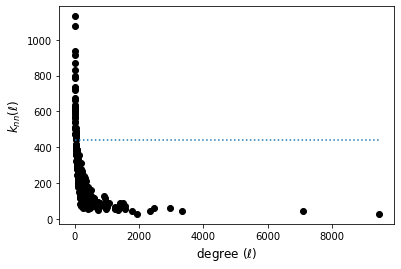

In [32]:
#QUESTION 01
#git hub correlated and uncorrelated function
knn = deg_corr(git)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(git)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_linear.eps')

#degree correlation coefficient
print("The degree correlation coefficient is ",git.assortativity_degree())
#correlation exponenet
print("The correlation exponent",corr_exp(git))




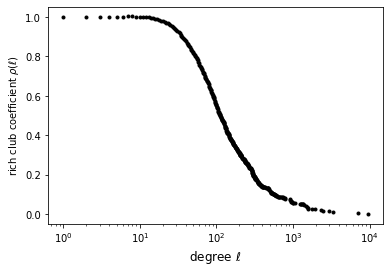

In [40]:
#plot rich club coefficeint
d = list(set(git.degree()))
rc = []
for i in d:
    rc.append(richClub(git, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
#plt.savefig('rich_club.eps');

The degree correlation coefficient is -0.09098692775064464
The correlation coefficient is -0.2514234876818035


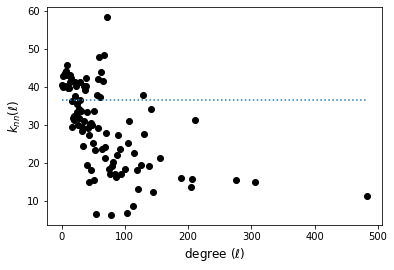

In [35]:
#git hub ml correlated and uncorrelated function
knn = deg_corr(gh_ml)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(gh_ml)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_linear.eps')

#degree correlation coefficient
print("The degree correlation coefficient is",gh_ml.assortativity_degree())
#correlation exponenet
print("The correlation coefficient is",corr_exp(gh_ml))
#plot rich club coefficeint
#print(richClub(gh_ml))


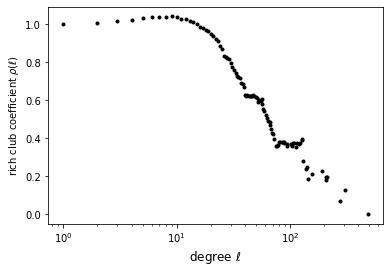

In [41]:
#plot rich club coefficeint
d = list(set(gh_ml.degree()))
rc = []
for i in d:
    rc.append(richClub(gh_ml, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
#plt.savefig('rich_club.eps');

The degree correlation coefficient is -0.08714757315866846
The correlation exponent is -0.5151040696086916


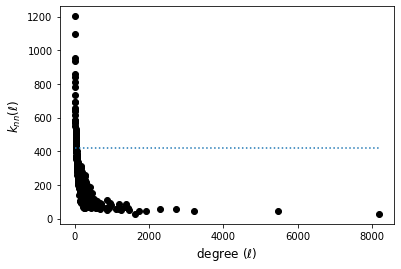

In [36]:
#git hub web correlated and uncorrelated function
knn = deg_corr(gh_web)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(gh_web)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_linear.eps')

#degree correlation coefficient
print("The degree correlation coefficient is",gh_web.assortativity_degree())
#correlation exponenet
print("The correlation exponent is",corr_exp(gh_web))
#plot rich club coefficeint
#print(richClub(gh_web))


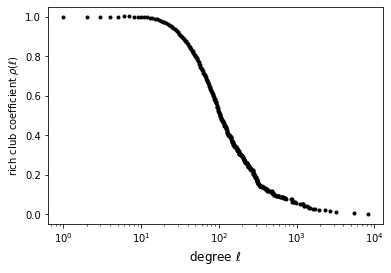

In [42]:
#plot rich club coefficeint
d = list(set(gh_web.degree()))
rc = []
for i in d:
    rc.append(richClub(gh_web, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
#plt.savefig('rich_club.eps');

In [7]:
#question 02 - generate cm graph
for i in range(100):    
    cm = ig.Graph.Degree_Sequence(git.degree(),method="vl")
print("done")

done


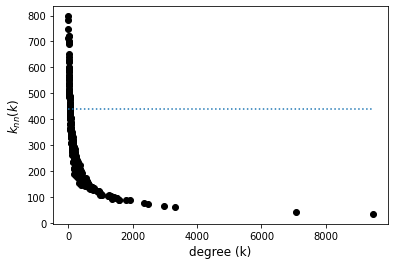

In [8]:
#question02 - generate knn from cm graph
knn = deg_corr(cm)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(cm)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel('degree (k)',fontsize=12)
plt.ylabel(r'$k_{nn}(k)$',fontsize=12);

In [ ]:
#QUESTION 03
#LET c = 0.5
#We need to do 0.5m edge switching which means we need to switch half the edges
#switching half the edges means switching half the nodes so we will split the 
#the list of vertices in half and only switch the nodes in one of the new lists
git.vs['degree'] = git.degree()
V = []
for v in git.vs():
    V.extend(np.repeat(v.index,v['degree']))

#split list of nodes in half
a1,a2 = np.array_split(V,2)
    
notdone = True
while notdone:
    np.random.shuffle(a1)
    notdone = False
    rg = ig.Graph()
    rg.add_vertices(np.max(a1)+1)
    for i in np.arange(0,len(a1),2):
        a, b = a1[i], a1[i+1]
        #checking for parallel edges
        #if edge exists between both nodes already then no new edge will be made
        if a == b or rg.get_eid(a,b,error=False) != -1:
            notdone = True
            break
        else:
            #add edge between nodes
            rg.add_edge(a,b)

In [ ]:
#LET c = 1
#We need to do m edge switching which means all the nodes in the graph have to be switched
#instead of a1 we can use V

notdone = True
while notdone:
    np.random.shuffle(V)
    notdone = False
    rg1 = ig.Graph()
    rg1.add_vertices(np.max(V)+1)
    for i in np.arange(0,len(V),2):
        a, b = V[i], V[i+1]
        #checking for parallel edges
        #if edge exists between both nodes already then no new edge will be made
        if a == b or rg1.get_eid(a,b,error=False) != -1:
            notdone = True
            break
        else:
            #add edge between nodes
            rg1.add_edge(a,b)


In [ ]:
#LET c = 2
#We need to do 2m edge switching which means all the nodes in the graph have to be switched
#and then switched again
#we will introduce a for loop and iterate twice

for rep in range(2):
    notdone = True
    while notdone:
        np.random.shuffle(V)
        notdone = False
        rg2 = ig.Graph()
        rg2.add_vertices(np.max(V)+1)
        for i in np.arange(0,len(V),2):
            a, b = V[i], V[i+1]
            #checking for parallel edges
            #if edge exists between both nodes already then no new edge will be made
            if a == b or rg2.get_eid(a,b,error=False) != -1:
                notdone = True
                break
            else:
                #add edge between nodes
                rg2.add_edge(a,b)

In [ ]:
# now we will plot knn of rg, rg1 and rg2
knn = deg_corr(rg)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(rg)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel('degree (k)',fontsize=12)
plt.ylabel(r'$k_{nn}(k)$',fontsize=12);

# knn = deg_corr(rg1)
# x = list(knn.keys())
# y = list(knn.values())
# r = deg_corr_neutral(rg1)
# plt.scatter(x,y,c='black')
# plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
# plt.xlabel('degree (k)',fontsize=12)
# plt.ylabel(r'$k_{nn}(k)$',fontsize=12);

# knn = deg_corr(rg2)
# x = list(knn.keys())
# y = list(knn.values())
# r = deg_corr_neutral(rg2)
# plt.scatter(x,y,c='black')
# plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
# plt.xlabel('degree (k)',fontsize=12)
# plt.ylabel(r'$k_{nn}(k)$',fontsize=12);

In [16]:
#QUESTION 05
## fast Chung-Lu: generate m edges w.r.t. distribution d
def fastCL(d, m):
    n = len(d)
    s = np.sum(d)
    p = [i/s for i in d]
    target = m
    tples = []
    ## generate edges (tuples), drop collisions, until m edges are obtained.
    while len(tples) < target:
        s = target - len(tples)
        e0 = np.random.choice(n, size=s, replace=True, p=p)
        e1 = np.random.choice(n, size=s, replace=True, p=p)
        tples.extend([(min(e0[i],e1[i]),max(e0[i],e1[i])) for i in range(len(e0)) if e0[i]!=e1[i]]) ## ignore loops
        tples = list(set(tples)) ## drop collisions
    return tples

In [17]:
#5 Chung-Lu model
## power law graph
gamma = 2.1
n = 10000

## min and max degrees
delta = 1
Delta = np.sqrt(n)

## generate degrees
W = []
for i in np.arange(1,n+1):
    W.append(delta * (n/(i-1+n/(Delta/delta)**(gamma-1)))**(1/(gamma-1)))

# deg = [int(np.round(w)) for w in W] ## to enforce integer weights, not an obligation
deg = W

## generate graph with Chung-Lu model
m = int(np.mean(deg)*n/2)
tpl = fastCL(deg,m)
g1 = ig.Graph.TupleList(tpl)

In [23]:
## power law graph
gamma = 2.5
n = 10000

## min and max degrees
delta = 1
Delta = np.sqrt(n)

## generate degrees
W = []
for i in np.arange(1,n+1):
    W.append(delta * (n/(i-1+n/(Delta/delta)**(gamma-1)))**(1/(gamma-1)))

# deg = [int(np.round(w)) for w in W] ## to enforce integer weights, not an obligation
deg = W

## generate graph with Chung-Lu model
m = int(np.mean(deg)*n/2)
tpl2 = fastCL(deg,m)
g2 = ig.Graph.TupleList(tpl2)

In [24]:
## power law graph
gamma = 2.9
n = 10000

## min and max degrees
delta = 1
Delta = np.sqrt(n)

## generate degrees
W = []
for i in np.arange(1,n+1):
    W.append(delta * (n/(i-1+n/(Delta/delta)**(gamma-1)))**(1/(gamma-1)))

# deg = [int(np.round(w)) for w in W] ## to enforce integer weights, not an obligation
deg = W

## generate graph with Chung-Lu model
m = int(np.mean(deg)*n/2)
tpl3 = fastCL(deg,m)
g3 = ig.Graph.TupleList(tpl3)

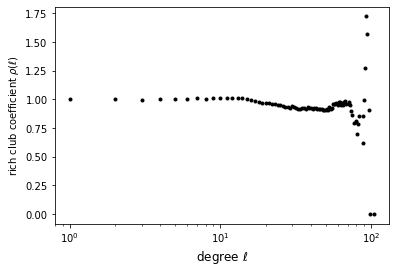

In [25]:
#Gamma 2.1 rich club behaviour
#plot rich club coefficeint
d = list(set(g1.degree()))
rc = []
for i in d:
    rc.append(richClub(g1, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
#plt.savefig('rich_club.eps');

r = -0.012429629810607436


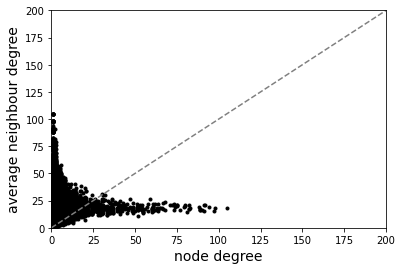

In [28]:
#friendship paradox
## plot degree vs avg neighbour degree
## friendship 'paradox' US Airport graph (overall)
deg = [v.degree() for v in g1.vs()]
nad = []
for v in g1.vs():
    nv = g1.neighbors(v)
    nad.append(np.mean([deg[i] for i in nv]))

plt.scatter(deg,nad,c='black',marker='.')
plt.xlim((0,200))
plt.ylim((0,200))
plt.xlabel('node degree', fontsize=14)
plt.ylabel('average neighbour degree', fontsize=14);
plt.plot([0,200],[0,200],'--', c='gray')
print('r =',g1.assortativity_degree());

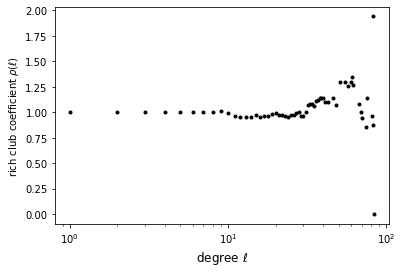

In [26]:
#Gamma 2.5 rich club behaviour
#plot rich club coefficeint
d = list(set(g2.degree()))
rc = []
for i in d:
    rc.append(richClub(g2, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
#plt.savefig('rich_club.eps');

r = 0.0008482634154723266


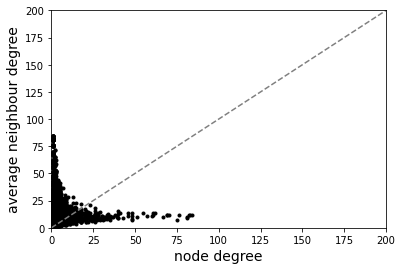

In [30]:
## plot degree vs avg neighbour degree
## friendship 'paradox' US Airport graph (overall)
deg = [v.degree() for v in g2.vs()]
nad = []
for v in g2.vs():
    nv = g2.neighbors(v)
    nad.append(np.mean([deg[i] for i in nv]))

plt.scatter(deg,nad,c='black',marker='.')
plt.xlim((0,200))
plt.ylim((0,200))
plt.xlabel('node degree', fontsize=14)
plt.ylabel('average neighbour degree', fontsize=14);
plt.plot([0,200],[0,200],'--', c='gray')
print('r =',g2.assortativity_degree());

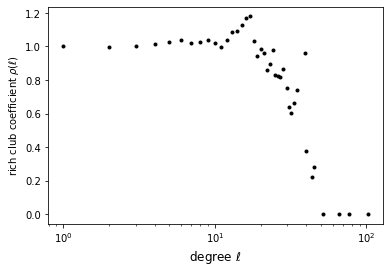

In [27]:
#Gamma 2.5 rich club behaviour
#plot rich club coefficeint
d = list(set(g3.degree()))
rc = []
for i in d:
    rc.append(richClub(g3, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
#plt.savefig('rich_club.eps');

r = -0.003520868988349116


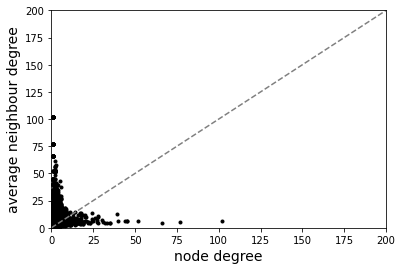

In [31]:
## plot degree vs avg neighbour degree
## friendship 'paradox' US Airport graph (overall)
deg = [v.degree() for v in g3.vs()]
nad = []
for v in g3.vs():
    nv = g3.neighbors(v)
    nad.append(np.mean([deg[i] for i in nv]))

plt.scatter(deg,nad,c='black',marker='.')
plt.xlim((0,200))
plt.ylim((0,200))
plt.xlabel('node degree', fontsize=14)
plt.ylabel('average neighbour degree', fontsize=14);
plt.plot([0,200],[0,200],'--', c='gray')
print('r =',g3.assortativity_degree());